# Statistical Data Analysis Project
Maximizing Driver Revenue Through Payment Type

# Project Purpose (Why This Project Exists)
### Business Problem

Taxi drivers earn revenue primarily from fares (and indirectly from tips). However, not all payment methods generate the same earnings. Drivers often do not know whether accepting or encouraging a specific payment type (Cash vs Card) affects their income.

### Objective
The purpose of this project is to:

Analyze whether payment type impacts driver revenue

Use statistical evidence to determine if one payment method is more profitable

Provide actionable recommendations to drivers and platforms

###  Importing Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import os 

### Initial Data Inspection

In [2]:
chunks = pd.read_csv('2023_Yellow_Taxi_Trip_Data.csv', nrows = 10, low_memory = False)
chunks

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,01/01/2023 12:32:10 AM,01/01/2023 12:40:36 AM,1,0.97,1,N,161,141,2,9.3,1.00,0.5,0.00,0,1,14.30,2.5,0.00
1,2,01/01/2023 12:55:08 AM,01/01/2023 01:01:27 AM,1,1.10,1,N,43,237,1,7.9,1.00,0.5,4.00,0,1,16.90,2.5,0.00
2,2,01/01/2023 12:25:04 AM,01/01/2023 12:37:49 AM,1,2.51,1,N,48,238,1,14.9,1.00,0.5,15.00,0,1,34.90,2.5,0.00
3,1,01/01/2023 12:03:48 AM,01/01/2023 12:13:25 AM,0,1.90,1,N,138,7,1,12.1,7.25,0.5,0.00,0,1,20.85,0.0,1.25
4,2,01/01/2023 12:10:29 AM,01/01/2023 12:21:19 AM,1,1.43,1,N,107,79,1,11.4,1.00,0.5,3.28,0,1,19.68,2.5,0.00
5,2,01/01/2023 12:50:34 AM,01/01/2023 01:02:52 AM,1,1.84,1,N,161,137,1,12.8,1.00,0.5,10.00,0,1,27.80,2.5,0.00
6,2,01/01/2023 12:09:22 AM,01/01/2023 12:19:49 AM,1,1.66,1,N,239,143,1,12.1,1.00,0.5,3.42,0,1,20.52,2.5,0.00
7,2,01/01/2023 12:27:12 AM,01/01/2023 12:49:56 AM,1,11.70,1,N,142,200,1,45.7,1.00,0.5,10.74,3,1,64.44,2.5,0.00
8,2,01/01/2023 12:21:44 AM,01/01/2023 12:36:40 AM,1,2.95,1,N,164,236,1,17.7,1.00,0.5,5.68,0,1,28.38,2.5,0.00
9,2,01/01/2023 12:39:42 AM,01/01/2023 12:50:36 AM,1,3.01,1,N,141,107,2,14.9,1.00,0.5,0.00,0,1,19.90,2.5,0.00


### Counting Rows & Understanding Dataset Size

In [3]:
chunks = pd.read_csv('2023_Yellow_Taxi_Trip_Data.csv', chunksize = 1_000_000, low_memory = False)

row_count = 0

for chunk in chunks:
    row_count += len(chunk)

print(row_count)


38310226


###  Assessing Columns and it's Length

In [4]:
cols = pd.read_csv("2023_Yellow_Taxi_Trip_Data.csv", nrows = 0).columns
print(list(cols))
print(len(cols))

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
19


### Handling Large Data Using Chunk Processing

In [5]:
chunks = pd.read_csv(
    "2023_Yellow_Taxi_Trip_Data.csv",
    chunksize=1_000_000,
    parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
    date_format={'tpep_pickup_datetime': '%m/%d/%Y %I:%M:%S %p',
                 'tpep_dropoff_datetime' : '%m/%d/%Y %I:%M:%S %p'},
    low_memory = False
)

output_file = "yellow_jan_feb_2023.csv"

if os.path.exists(output_file):
    os.remove(output_file)

first_chunk = True

for chunk in chunks:
    filtered = chunk[
        (chunk['tpep_pickup_datetime'] >= '2023-01-01') &
        (chunk['tpep_pickup_datetime'] <  '2023-03-01')
    ]

    if not filtered.empty:
        filtered.to_csv(
            output_file,
            mode='a',              
            header=first_chunk,
            index=False
        )
        first_chunk = False


### Selecting Relevant Columns

In [6]:
selected_columns = ['tpep_pickup_datetime','tpep_dropoff_datetime', 
                    'passenger_count', 'trip_distance', 'payment_type', 'fare_amount']
df = pd.read_csv("yellow_jan_feb_2023.csv", 
                low_memory = False, usecols = selected_columns,
                parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime'])

df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,2,9.3
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1,7.9
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1,14.9
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1,12.1
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1,11.4


# Exploratory Data Analysis

### Shape & Data Type Validation

In [7]:
df.shape

(5980729, 6)

In [8]:
df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
payment_type                      int64
fare_amount                     float64
dtype: object

### Feature Engineering: Trip Duration

In [9]:
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,duration
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,2,9.3,8.433333
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1,7.9,6.316667
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1,14.9,12.750000
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1,12.1,9.616667
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1,11.4,10.833333


### Missing Value Analysis

In [10]:
df.isnull().sum()

tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          148560
trip_distance                 0
payment_type                  0
fare_amount                   0
duration                      0
dtype: int64

In [11]:
(148560/len(df)) * 100

2.4839781237370895

### Dropping Missing Values

In [12]:
df = df.dropna()
df.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
payment_type             0
fare_amount              0
duration                 0
dtype: int64

### Data Type Corrections

In [13]:
for col in ['passenger_count', 'payment_type']:
    df[col] = df[col].astype('int64')

df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
payment_type                      int64
fare_amount                     float64
duration                        float64
dtype: object

### Duplicate Detection & Removal

In [14]:
df.duplicated().sum()

np.int64(308)

In [15]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

### Distribution Check: Passenger Count & Payment Type

In [16]:
df['passenger_count'].value_counts(normalize= True) * 100

passenger_count
1    75.857072
2    14.849668
3     3.498729
4     1.747041
0     1.687986
5     1.417438
6     0.941483
8     0.000309
7     0.000154
9     0.000120
Name: proportion, dtype: float64

In [17]:
df['payment_type'].value_counts(normalize = True) * 100

payment_type
1    80.952255
2    17.307597
4     1.120654
3     0.619494
Name: proportion, dtype: float64

### Filtering Valid Payment Types & Passenger Count

In [18]:
df = df[df['payment_type'] < 3]
df = df[df['passenger_count'].between(1,5)]

### Rechecking The Shape

In [19]:
df.shape

(5580107, 7)

### Label Encoding Payment Types

In [20]:
df['payment_type'] = df['payment_type'].replace([1,2], ['Card','Cash'])
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,duration
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1,0.97,Cash,9.30,8.433333
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1,1.10,Card,7.90,6.316667
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1,2.51,Card,14.90,12.750000
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1,1.43,Card,11.40,10.833333
5,2023-01-01 00:50:34,2023-01-01 01:02:52,1,1.84,Card,12.80,12.300000
...,...,...,...,...,...,...,...
5980724,2023-02-27 15:50:14,2023-02-27 15:54:41,1,0.00,Cash,5.10,4.450000
5980725,2023-02-27 15:54:32,2023-02-27 16:01:42,1,0.00,Card,7.20,7.166667
5980726,2023-02-27 16:32:29,2023-02-27 16:35:16,1,0.00,Card,21.31,2.783333
5980727,2023-02-27 17:04:48,2023-02-27 17:06:02,1,0.00,Card,21.31,1.233333


### Descriptive Statistics (Pre-Filtering)

In [21]:
df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,duration
count,5580107,5580107,5.580107e+06,5.580107e+06,5.580107e+06,5.580107e+06
mean,2023-01-31 03:26:14.977908480,2023-01-31 03:42:08.016091136,1.337272e+00,3.412068e+00,1.853503e+01,1.588397e+01
min,2023-01-01 00:00:05,2023-01-01 00:03:28,1.000000e+00,0.000000e+00,-5.530000e+02,-4.361667e+01
25%,2023-01-16 17:26:17.500000,2023-01-16 17:43:16,1.000000e+00,1.070000e+00,8.600000e+00,7.216667e+00
50%,2023-01-31 10:00:08,2023-01-31 10:16:38,1.000000e+00,1.790000e+00,1.280000e+01,1.163333e+01
75%,2023-02-14 17:10:29.500000,2023-02-14 17:28:42,1.000000e+00,3.300000e+00,2.050000e+01,1.846667e+01
max,2023-02-28 23:59:58,2023-03-01 22:01:59,5.000000e+00,6.235952e+04,2.203100e+03,1.002918e+04
std,NaN,NaN,7.612562e-01,3.463595e+01,1.739567e+01,4.325656e+01


### Logical Validity Filtering

In [22]:
df = df[
    (df['duration'] > 0) &
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0) &
    (df['tpep_pickup_datetime'].dt.year == 2023) &
    (df['tpep_dropoff_datetime'].dt.year == 2023)
]

In [23]:
df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,duration
count,5511631,5511631,5.511631e+06,5.511631e+06,5.511631e+06,5.511631e+06
mean,2023-01-31 03:27:28.529127680,2023-01-31 03:43:24.066292224,1.337816e+00,3.435776e+00,1.850006e+01,1.592562e+01
min,2023-01-01 00:00:05,2023-01-01 00:04:32,1.000000e+00,1.000000e-02,1.000000e-02,1.666667e-02
25%,2023-01-16 17:29:47,2023-01-16 17:46:49,1.000000e+00,1.100000e+00,8.600000e+00,7.283333e+00
50%,2023-01-31 10:00:42,2023-01-31 10:17:20,1.000000e+00,1.800000e+00,1.280000e+01,1.168333e+01
75%,2023-02-14 17:09:46.500000,2023-02-14 17:27:55.500000,1.000000e+00,3.320000e+00,1.980000e+01,1.850000e+01
max,2023-02-28 23:59:58,2023-03-01 22:01:59,5.000000e+00,1.745683e+04,1.160100e+03,7.053617e+03
std,NaN,NaN,7.620017e-01,2.255880e+01,1.690206e+01,4.295001e+01


### Outlier Visualization

<Axes: ylabel='fare_amount'>

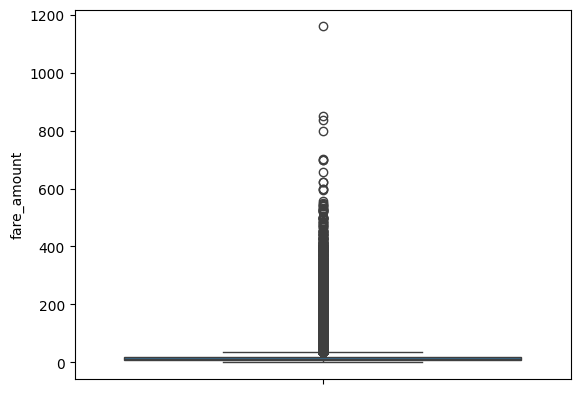

In [24]:
sns.boxplot(data = df, y = 'fare_amount')

### Outlier Removal (IQR Method)

In [25]:
for col in ['duration', 'trip_distance', 'fare_amount']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df = df[(df[col] > lower_bound) & (df[col] < upper_bound )]


In [26]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,duration
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1,0.97,Cash,9.3,8.433333
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1,1.10,Card,7.9,6.316667
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1,2.51,Card,14.9,12.750000
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1,1.43,Card,11.4,10.833333
5,2023-01-01 00:50:34,2023-01-01 01:02:52,1,1.84,Card,12.8,12.300000
...,...,...,...,...,...,...,...
5980644,2023-02-28 23:59:43,2023-03-01 00:09:25,1,2.88,Card,13.5,9.700000
5980645,2023-02-28 23:58:35,2023-03-01 00:08:16,5,1.69,Card,11.4,9.683333
5980647,2023-02-28 23:56:03,2023-03-01 00:06:31,1,1.79,Card,12.1,10.466667
5980648,2023-02-28 23:55:38,2023-03-01 00:00:46,1,1.58,Card,8.6,5.133333


### Fare & Distance Distribution by Payment Type

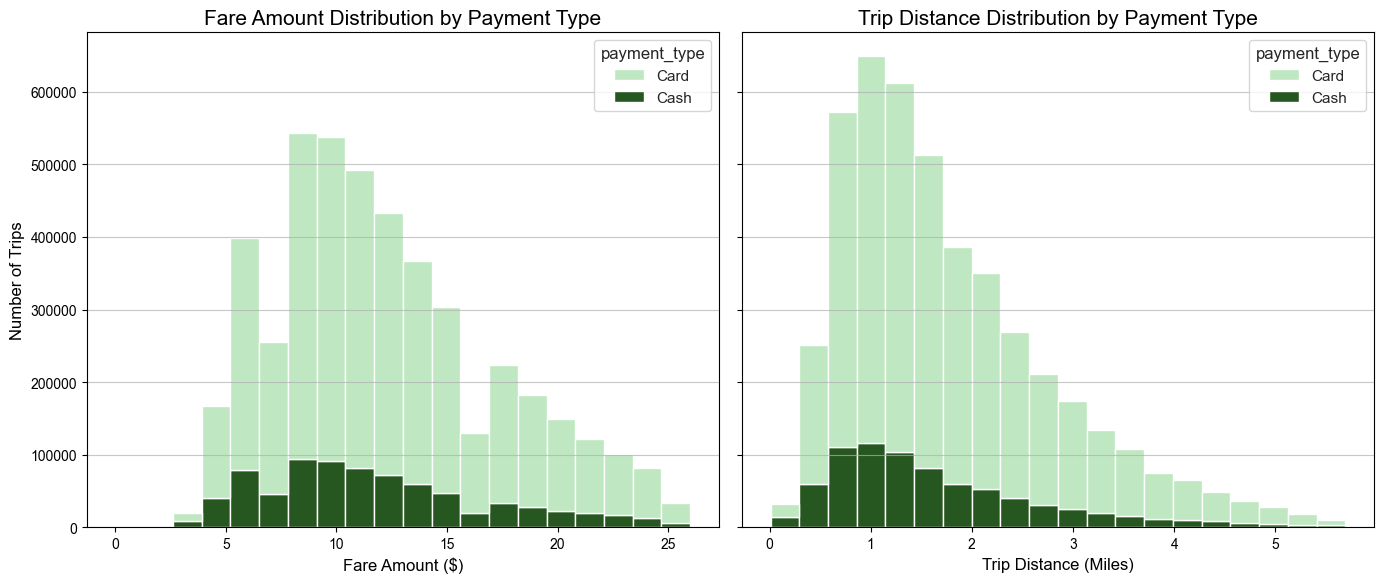

In [27]:
fig,axes = plt.subplots(1,2, figsize = (14,6), sharey = True)

sns.set_theme(style = 'white')

palette = {
    'Card' : "#B8E5BB",
    'Cash' : "#0F4507FF"
}

hue_order = ['Card','Cash']

sns.histplot(data = df, x = 'fare_amount', hue = 'payment_type',
             bins = 20, element= 'bars', ax = axes[0], palette = palette,
             hue_order= hue_order, alpha = 0.9, multiple= 'stack')

axes[0].set_xlabel('Fare Amount ($)', fontsize = 12, color = 'black')
axes[0].set_ylabel('Number of Trips', fontsize = 12, color = 'black')
axes[0].set_title('Fare Amount Distribution by Payment Type', fontsize = 15, color = 'black')
axes[0].grid(axis = 'y', alpha = 0.7)

sns.histplot(data = df , x = 'trip_distance', hue = 'payment_type', 
             bins = 20, element = 'bars', ax = axes[1], palette = palette,
             hue_order= hue_order, alpha = 0.9, multiple= 'stack')

axes[1].set_xlabel('Trip Distance (Miles)', fontsize = 12, color = 'black')
axes[1].set_title('Trip Distance Distribution by Payment Type', fontsize = 15, color = 'black')
axes[1].grid(axis = 'y', alpha = 0.7)

plt.tight_layout()
plt.show()

### Grouped Summary Statistics

In [28]:
df.groupby('payment_type').agg(
    fare_amount_mean = ('fare_amount','mean'),
    fare_amount_std = ('fare_amount','std'),
    trip_distance_mean = ('trip_distance', 'mean'),
    trip_distance_std = ('trip_distance','std')).reset_index()

,payment_type,fare_amount_mean,fare_amount_std,trip_distance_mean,trip_distance_std
0,Card,12.340612,4.987938,1.789021,1.035541
1,Cash,11.778212,5.041701,1.664266,1.064697


### Payment Preference Pie Chart

(np.float64(-1.1512363578456868),
 np.float64(1.0487634527198608),
 np.float64(-1.1901705700192078),
 np.float64(1.1042938366675814))

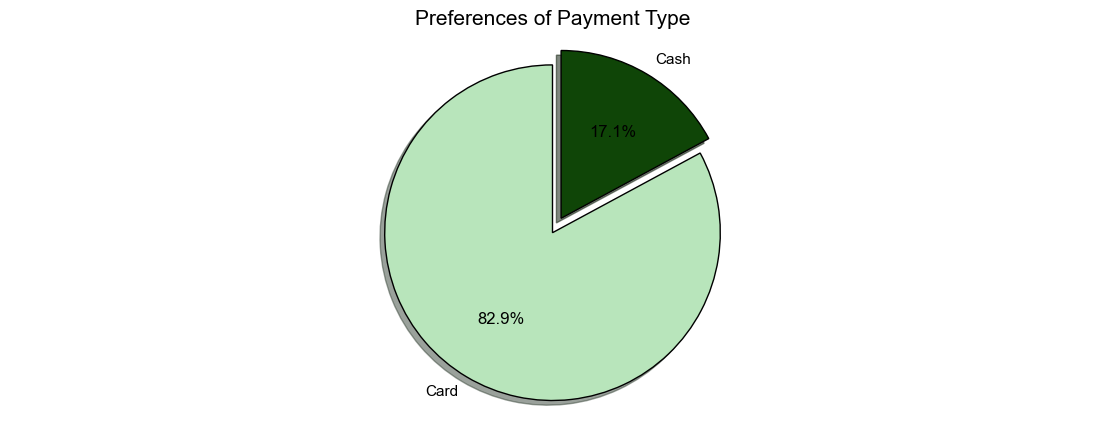

In [29]:
fig,ax = plt.subplots(figsize = (14,5))

ax.pie(x = df['payment_type'].value_counts(normalize = True), 
        labels = df['payment_type'].value_counts().index,
        shadow= True, autopct = '%1.1f%%', 
        startangle= 90, explode= [0.1, 0.0],
        wedgeprops= dict(edgecolor = 'black'),
        colors= ["#B8E5BB","#0F4507FF"],
        textprops= dict(color = 'black'),
        )

ax.set_title('Preferences of Payment Type', fontsize = 15, color = 'black')

ax.axis('equal')


### Passenger Count vs Payment Type

In [30]:
passenger_group = df.groupby(['payment_type','passenger_count'])\
    .size().reset_index(name = 'count')
passenger_group

,payment_type,passenger_count,count
0,Card,1,2975298
1,Card,2,545853
2,Card,3,128602
3,Card,4,57994
4,Card,5,56435
5,Cash,1,590387
6,Cash,2,124897
7,Cash,3,31567
8,Cash,4,19107
9,Cash,5,11751


### Contribution Of Passenger Count 

In [31]:
passenger_group['perc'] = (passenger_group['count']/ passenger_group['count'].sum()) * 100
passenger_group

,payment_type,passenger_count,count,perc
0,Card,1,2975298,65.507913
1,Card,2,545853,12.018188
2,Card,3,128602,2.831464
3,Card,4,57994,1.276869
4,Card,5,56435,1.242544
5,Cash,1,590387,12.998705
6,Cash,2,124897,2.749890
7,Cash,3,31567,0.695019
8,Cash,4,19107,0.420684
9,Cash,5,11751,0.258725


### Pivoting The Result Data

In [32]:
pivot_df = passenger_group.pivot(index = 'payment_type', values = 'perc', columns = 'passenger_count')
pivot_df

passenger_count,1,2,3,4,5
payment_type,,,,,
Card,65.507913,12.018188,2.831464,1.276869,1.242544
Cash,12.998705,2.749890,0.695019,0.420684,0.258725


### Contribution Of Passenger Count In Payment Type Using Stacked Bar

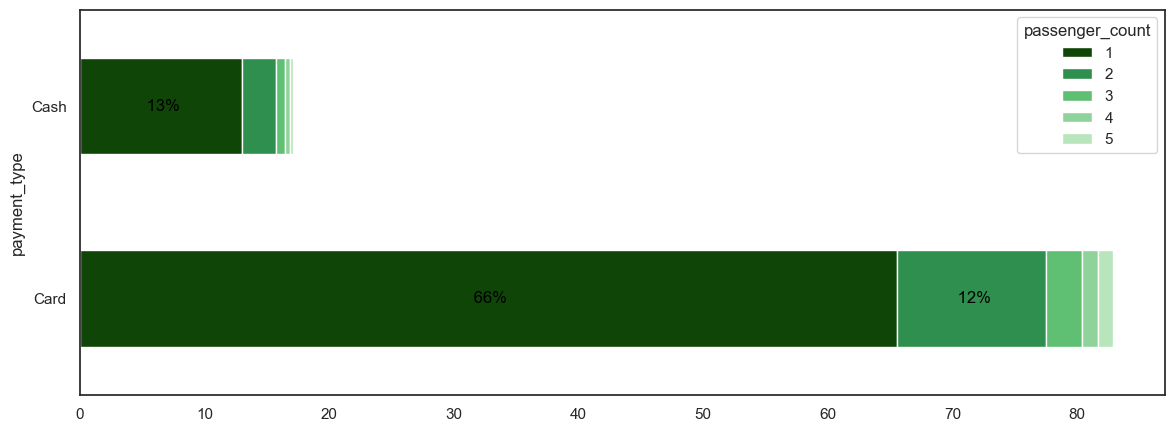

In [33]:
palette = [
    "#0F4507",
    "#2F8F4E",
    "#5FBF73",
    "#8FD39A", 
    "#B8E5BB"    
]

ax = pivot_df.plot(kind = 'barh',
                   stacked = True,
                   color = palette, figsize = (14,5) )

for p in ax.patches:
    value = p.get_width()
    height = p.get_height()
    x,y = p.get_xy()
    if value > 3:
      ax.text(
          x + value / 2,
          y + height / 2,
          format(f'{value : .0f}%'),
          ha = 'center',
          va = 'center',
          fontsize = 12,
          color = 'black'
    )


### Sample Extraction for Testing

In [34]:
card_sample = df.loc[df['payment_type'] == 'Card','fare_amount']
cash_sample = df.loc[df['payment_type'] == 'Cash','fare_amount']
card_sample

1           7.9
2          14.9
4          11.4
5          12.8
6          12.1
           ... 
5980640    16.3
5980644    13.5
5980645    11.4
5980647    12.1
5980648     8.6
Name: fare_amount, Length: 3764182, dtype: float64

### Normality Check (QQ Plot)

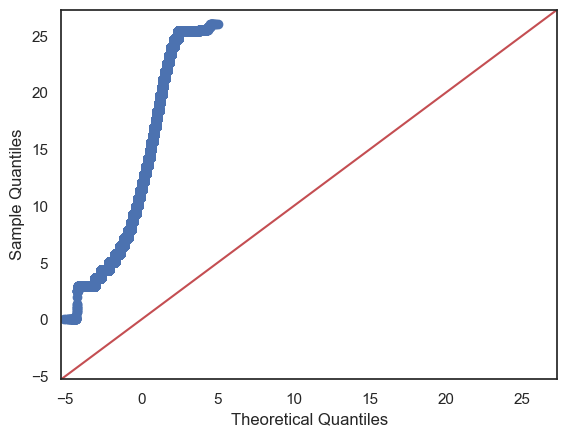

In [35]:
sm.qqplot(df['fare_amount'], line = '45')
plt.show()

## Assumptions
### Null Hypothesis : There Is No Significat Difference In Payment Type
### Alternative Hypothesis : There Is a Significant Difference In Payment Type

### Hypothesis Testing (Welch’s t-test)

In [36]:
t_stats, p_value = st.ttest_ind(a = card_sample, b = cash_sample, equal_var= False)
print(t_stats,p_value)

89.71890068105662 0.0


## Final Conclusion

### p-value < 0.05

### Null hypothesis rejected

### Payment type significantly impacts driver revenue